In [0]:
import os
import warnings
import sys
 
import pandas as pd
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

In [0]:
# Import mlflow
import mlflow
import mlflow.sklearn

In [0]:
# Load diabetes dataset
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target
 
# Create pandas DataFrame 
Y = np.array([y]).transpose()
d = np.concatenate((X, Y), axis=1)
cols = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'progression']
data = pd.DataFrame(d, columns=cols)

In [0]:
data.head()

Out[4]:

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [0]:
def plot_enet_descent_path(X, y, l1_ratio):
    # Compute paths
    eps = 5e-3  # the smaller it is the longer is the path
 
    # Reference the global image variable
    global image
    
    print("Computing regularization path using ElasticNet.")
    alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=l1_ratio, fit_intercept=False)
 
    # Display results
    fig = plt.figure(1)
    ax = plt.gca()
 
    colors = cycle(['b', 'r', 'g', 'c', 'k'])
    neg_log_alphas_enet = -np.log10(alphas_enet)
    for coef_e, c in zip(coefs_enet, colors):
        l1 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)
 
    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    title = 'ElasticNet Path by alpha for l1_ratio = ' + str(l1_ratio)
    plt.title(title)
    plt.axis('tight')
 
    # Display images
    image = fig
    
    # Save figure
    fig.savefig("ElasticNet-paths.png")
 
    # Close plot
    plt.close(fig)
 
    # Return images
    return image    

In [0]:
# train_diabetes
#   Uses the sklearn Diabetes dataset to predict diabetes progression using ElasticNet
#       The predicted "progression" column is a quantitative measure of disease progression one year after baseline
#       http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html
def train_diabetes(data, in_alpha, in_l1_ratio):
  
  # Evaluate metrics
  def eval_metrics(actual, pred):
      rmse = np.sqrt(mean_squared_error(actual, pred))
      mae = mean_absolute_error(actual, pred)
      r2 = r2_score(actual, pred)
      return rmse, mae, r2
 
  warnings.filterwarnings("ignore")
  np.random.seed(40)
 
  # Split the data into training and test sets. (0.75, 0.25) split.
  train, test = train_test_split(data)
 
  # The predicted column is "progression" which is a quantitative measure of disease progression one year after baseline
  train_x = train.drop(["progression"], axis=1)
  test_x = test.drop(["progression"], axis=1)
  train_y = train[["progression"]]
  test_y = test[["progression"]]
 
  if float(in_alpha) is None:
    alpha = 0.05
  else:
    alpha = float(in_alpha)
    
  if float(in_l1_ratio) is None:
    l1_ratio = 0.05
  else:
    l1_ratio = float(in_l1_ratio)
  
  # Start an MLflow run; the "with" keyword ensures we'll close the run even if this cell crashes
  mlflow.sklearn.autolog()
  with mlflow.start_run():
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_x, train_y)
 
    predicted_qualities = lr.predict(test_x)
 
    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)
 
    # Print out ElasticNet model metrics
    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
 
    # Log mlflow attributes for mlflow UI
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(lr, "model")
    modelpath = "/dbfs/mlflow/test_diabetes/model-%f-%f" % (alpha, l1_ratio)
    mlflow.sklearn.save_model(lr, modelpath)
    
    # Call plot_enet_descent_path
    image = plot_enet_descent_path(X, y, l1_ratio)
    
    # Log artifacts (output files)
    mlflow.log_artifact("ElasticNet-paths.png")

In [0]:
%fs rm -r dbfs:/mlflow/test_diabetes

res0: Boolean = false

In [0]:
train_diabetes(data, 0.01, 0.01)

Elasticnet model (alpha=0.010000, l1_ratio=0.010000):
 RMSE: 71.40362571026475
 MAE: 60.09124839565383
 R2: 0.2291130640003659
Computing regularization path using ElasticNet.

In [0]:
train_diabetes(data, 0.02, 0.01)

Elasticnet model (alpha=0.020000, l1_ratio=0.010000):
 RMSE: 75.00025453668066
 MAE: 63.288128416581465
 R2: 0.14949742881490502
Computing regularization path using ElasticNet.

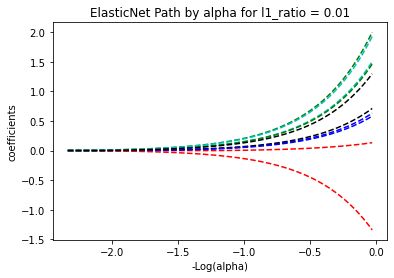

In [0]:
display(image)

In [0]:
train_diabetes(data, 0.01, .5)

Elasticnet model (alpha=0.010000, l1_ratio=0.500000):
 RMSE: 67.98354871814037
 MAE: 56.73838604280737
 R2: 0.30119208073981796
Computing regularization path using ElasticNet.